# Forward encoding model based on Pim Mostert Decoding toolbox



In [1]:
!pwd

/Users/junjieji/Documents/GitHub/master-thesis


In [2]:
import sys
import time as tic
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


# Variables

In [3]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 26 # Change the range so the process is faster
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
nSubj = len(subjs_list)

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = True # speeds up the procees but showing worse results overall
if resample: resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [4]:
'''EEG Dataset'''
def read_data(number_of_repetition,
              resample,
              resample_frequency,
              subjs_list = subjs_list
              ):
    path = 'Cond_CJ_EEG'

    all_st_epochs = []
    all_st_rawdata = []
    for subject_id in subjs_list:
        preproc_path = os.path.join(path, subject_id)
        
        st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
        # print(st_epoch.info['sfreq'])
        if resample: 
            print('Frequency before:', st_epoch.info['sfreq'])
            st_epoch = st_epoch.resample(resample_frequency)
            print('Frequency after:' ,st_epoch.info['sfreq'])
            
        all_st_epochs.append(st_epoch)
        all_st_rawdata.append(
            {
            'epoch_dat': st_epoch.get_data()[st_epoch.metadata['nrep'] == number_of_repetition,:,:] ,
            'metadata': st_epoch.metadata[st_epoch.metadata['nrep'] == number_of_repetition]
            }
            )
    return all_st_rawdata


# Procedure for multisubject

In [23]:
from decoding_toolbox_py.Helper_funcs.DecToolbox import CreateFolds, CV_encoder
from decoding_toolbox_py.Helper_funcs import DecToolbox as dt
def train(all_st_rawdata, raw_predicts = False):
    nSubj = len(all_st_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        Y = all_st_rawdata[subj]['epoch_dat']
        Y = np.einsum('kji->jik', Y)
        print(Y.shape)
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_st_rawdata[subj]['metadata'].orient)
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
        print('preds', np.shape(preds[0]))
    if raw_predicts:
        return preds
        
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        print('Xhat_centeredmean', np.shape(Xhat_centeredmean))
        return Xhat_centeredmean

def train_shifted_2(all_st_rawdata, raw_predicts = False):
    nSubj = len(all_st_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        Y = all_st_rawdata[subj]['epoch_dat']
        Y = np.einsum('kji->jik', Y)
        print(Y.shape)
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_st_rawdata[subj]['metadata'].orient)
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
        print('preds', np.shape(preds[0]))
    if raw_predicts:
        return preds
        
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], 0, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        return Xhat_centeredmean
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        print('Xhat_centeredmean', np.shape(Xhat_centeredmean))
        return Xhat_centeredmean        

def train_shifted(all_st_rawdata, raw_predicts = False, orthogonal = False):
    nSubj = len(all_st_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        Y = all_st_rawdata[subj]['epoch_dat']
        Y = np.einsum('kji->jik', Y)
        print(Y.shape)
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_st_rawdata[subj]['metadata'].orient)
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
        print('preds', np.shape(preds[0]))
    if raw_predicts:
        return preds
        
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for subj in range(nSubj):
            Xhat = preds[subj]
            Xhat_centered = Xhat.copy()
            
            # for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
            if orthogonal:
                loop = [0,3,4,7]
            else:
                loop = [1,2,5,6]
            for ic in loop: # ortogonal shifts
                aux = ic % 2
                if aux in [1]:
                    aux == 4
                else:
                    aux == 0
                Xhat_centered[:, G[subj] == ic,:] = np.roll(Xhat[:,G[subj] == ic,:], 0 , axis = 0)
                m_centered[:,ic, :, subj] =  np.mean( Xhat_centered[:,  G[subj] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        print('Xhat_centeredmean', np.shape(Xhat_centeredmean))
        return Xhat_centeredmean
    


In [12]:
from toolbox.methods import read_data_repetitions_decision, read_data
all_st_epoch, all_st_rawdata = read_data(
    amount_of_subjects=26, task='stim',
    repetitions = False,
    resample = True, resample_frequency=50)

# all_st_epoch, all_st_rawdata_rep_0 = read_data(
#     amount_of_subjects=26, task='stim',
#     repetitions = True,
#     repetition_index=0,
#     resample = True, resample_frequency=50)
# 
# _ , all_st_rawdata_rep_1 = read_data(
#     amount_of_subjects=26, task='stim',
#     repetitions = True,
#     repetition_index=1,
#     resample = True, resample_frequency=50)
# 
# _ , all_st_rawdata_rep_2 = read_data(
#     amount_of_subjects=26, task='stim',
#     repetitions = True,
#     repetition_index=2,
#     resample = True, resample_frequency=50)


all_st_rawdata_deci0 = read_data_repetitions_decision(
    amount_of_subjects=26, task='stim',
    repetition_index=1 ,
    decision_index=0,
    resample=True, resample_frequency=50)

all_st_rawdata_deci1 = read_data_repetitions_decision(
    amount_of_subjects=26, task='stim',
    repetition_index=2,
    decision_index=1,
    resample=True, resample_frequency=50)

Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency after: 50.0
Frequency before: 500.0
Frequency 

In [7]:
print(all_st_epoch[0].times.shape)
time_labels = all_st_epoch[0].times 
time_labels = time_labels * 1000 # in ms
time_labels = time_labels.astype(int)
time_labels

(20,)


array([-100,  -80,  -60,  -40,  -20,    0,   19,   40,   60,   79,  100,
        120,  139,  160,  180,  199,  220,  240,  260,  280])

In [8]:
time_labels = [-100,  -80,  -60,  -40,  -20,    0,   20,   40,   60,   80,  100,
        120,  140,  160,  180,  200,  220,  240,  260,  280]
# the int wasnt working properly here

In [24]:
Xhat_centeredmean_shifted = train_shifted_2(all_st_rawdata)


(32, 20, 1563)
preds (8, 1563, 20)
(32, 20, 1396)
preds (8, 1563, 20)
(32, 20, 1470)
preds (8, 1563, 20)
(32, 20, 1415)
preds (8, 1563, 20)
(32, 20, 1532)
preds (8, 1563, 20)
(32, 20, 1409)
preds (8, 1563, 20)
(32, 20, 1528)
preds (8, 1563, 20)
(32, 20, 1187)
preds (8, 1563, 20)
(32, 20, 1513)
preds (8, 1563, 20)
(32, 20, 1282)
preds (8, 1563, 20)
(32, 20, 1435)
preds (8, 1563, 20)
(32, 20, 1581)
preds (8, 1563, 20)
(32, 20, 1582)
preds (8, 1563, 20)
(32, 20, 1470)
preds (8, 1563, 20)
(32, 20, 1331)
preds (8, 1563, 20)
(32, 20, 1580)
preds (8, 1563, 20)
(32, 20, 1500)
preds (8, 1563, 20)
(32, 20, 1490)
preds (8, 1563, 20)
(32, 20, 1543)
preds (8, 1563, 20)
(32, 20, 1334)
preds (8, 1563, 20)
(32, 20, 1501)
preds (8, 1563, 20)
(32, 20, 1139)
preds (8, 1563, 20)
(32, 20, 1427)
preds (8, 1563, 20)
(32, 20, 1388)
preds (8, 1563, 20)
(32, 20, 1473)
preds (8, 1563, 20)
(32, 20, 1542)
preds (8, 1563, 20)


In [25]:
np.save('Xhat_centeredmean_separate_subjects_shifted.npy', Xhat_centeredmean_shifted)

In [14]:
Xhat_centeredmean = train_shifted(all_st_rawdata, orthogonal = True)

# Xhat_centeredmean_rep_0 = train_shifted(all_st_rawdata_rep_0, orthogonal = True)
# Xhat_centeredmean_rep_1 = train_shifted(all_st_rawdata_rep_1, orthogonal = True)
# Xhat_centeredmean_rep_2 = train_shifted(all_st_rawdata_rep_2, orthogonal = True)

Xhat_centeredmean_deci0 = train_shifted(all_st_rawdata_deci0, orthogonal = False)
Xhat_centeredmean_deci1 = train_shifted(all_st_rawdata_deci1, orthogonal = False)
Xhat_centeredmean_ort = train_shifted(all_st_rawdata, orthogonal = True)
Xhat_centeredmean_deci0_ort = train_shifted(all_st_rawdata_deci0, orthogonal = True)
Xhat_centeredmean_deci1_ort = train_shifted(all_st_rawdata_deci1, orthogonal = True)


(32, 20, 1563)
preds (8, 1563, 20)
(32, 20, 1396)
preds (8, 1563, 20)
(32, 20, 1470)
preds (8, 1563, 20)
(32, 20, 1415)
preds (8, 1563, 20)
(32, 20, 1532)
preds (8, 1563, 20)
(32, 20, 1409)
preds (8, 1563, 20)
(32, 20, 1528)
preds (8, 1563, 20)
(32, 20, 1187)
preds (8, 1563, 20)
(32, 20, 1513)
preds (8, 1563, 20)
(32, 20, 1282)
preds (8, 1563, 20)
(32, 20, 1435)
preds (8, 1563, 20)
(32, 20, 1581)
preds (8, 1563, 20)
(32, 20, 1582)
preds (8, 1563, 20)
(32, 20, 1470)
preds (8, 1563, 20)
(32, 20, 1331)
preds (8, 1563, 20)
(32, 20, 1580)
preds (8, 1563, 20)
(32, 20, 1500)
preds (8, 1563, 20)
(32, 20, 1490)
preds (8, 1563, 20)
(32, 20, 1543)
preds (8, 1563, 20)
(32, 20, 1334)
preds (8, 1563, 20)
(32, 20, 1501)
preds (8, 1563, 20)
(32, 20, 1139)
preds (8, 1563, 20)
(32, 20, 1427)
preds (8, 1563, 20)
(32, 20, 1388)
preds (8, 1563, 20)
(32, 20, 1473)
preds (8, 1563, 20)
(32, 20, 1542)
preds (8, 1563, 20)
Xhat_centeredmean (8, 20)
(32, 20, 351)
preds (8, 351, 20)
(32, 20, 333)
preds (8, 351, 20

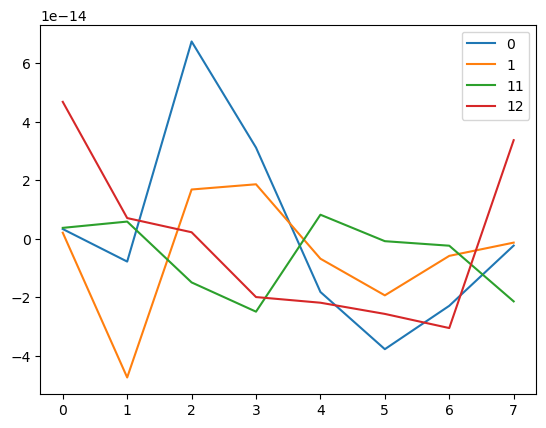

In [22]:
plt.plot(Xhat_centeredmean_shifted[:,0], label='0')
plt.plot(Xhat_centeredmean_shifted[:,1], label='1')
plt.plot(Xhat_centeredmean_shifted[:,11], label='11')
plt.plot(Xhat_centeredmean_shifted[:,12], label='12')
plt.legend()

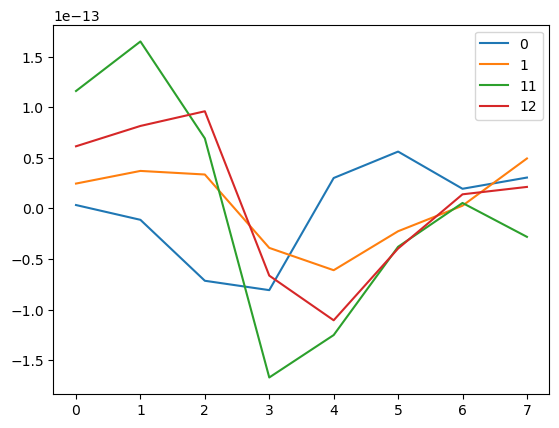

In [16]:
plt.plot(Xhat_centeredmean_deci0[:,0], label='0')
plt.plot(Xhat_centeredmean_deci0[:,1], label='1')
plt.plot(Xhat_centeredmean_deci0[:,11], label='11')
plt.plot(Xhat_centeredmean_deci0[:,12], label='12')
plt.legend()

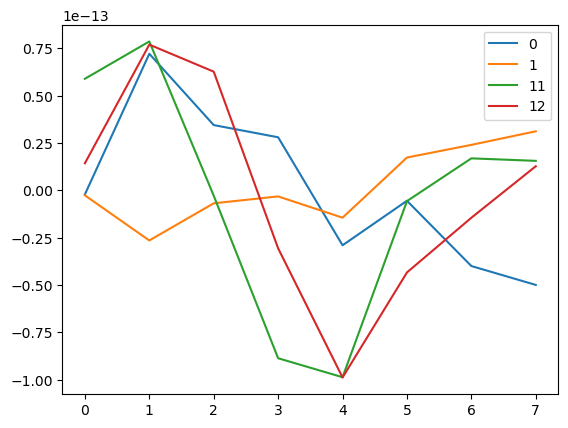

In [26]:
plt.plot(Xhat_centeredmean_deci1[:,0], label='0')
plt.plot(Xhat_centeredmean_deci1[:,1], label='1')
plt.plot(Xhat_centeredmean_deci1[:,11], label='11')
plt.plot(Xhat_centeredmean_deci1[:,12], label='12')
plt.legend()

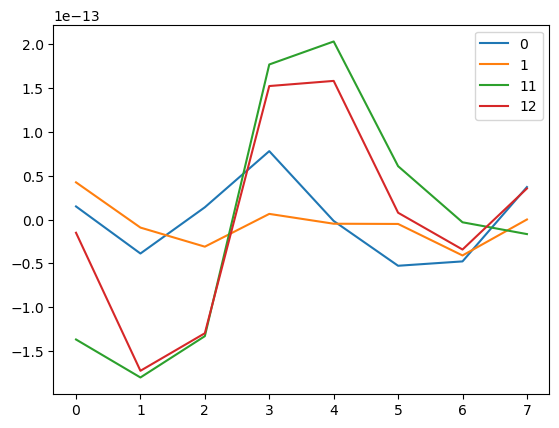

In [15]:
plt.plot(Xhat_centeredmean_ort[:,0], label='0')
plt.plot(Xhat_centeredmean_ort[:,1], label='1')
plt.plot(Xhat_centeredmean_ort[:,11], label='11')
plt.plot(Xhat_centeredmean_ort[:,12], label='12')
plt.legend()

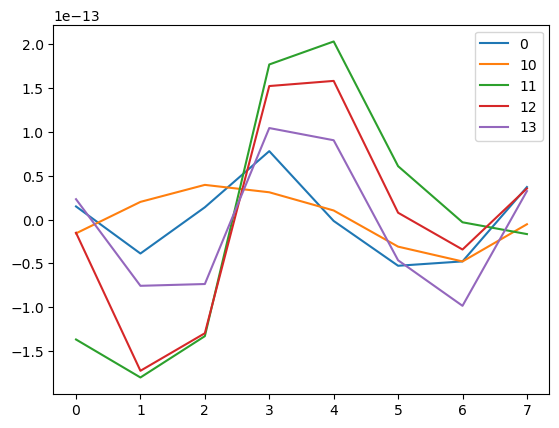

In [30]:
plt.plot(Xhat_centeredmean_ort[:,0:1].mean(axis=1), label='0')
plt.plot(Xhat_centeredmean_ort[:,10:11].mean(axis=1), label='10')
plt.plot(Xhat_centeredmean_ort[:,11:12].mean(axis=1), label='11')
plt.plot(Xhat_centeredmean_ort[:,12:13].mean(axis=1), label='12')
plt.plot(Xhat_centeredmean_ort[:,13:14].mean(axis=1), label='13')
plt.legend()


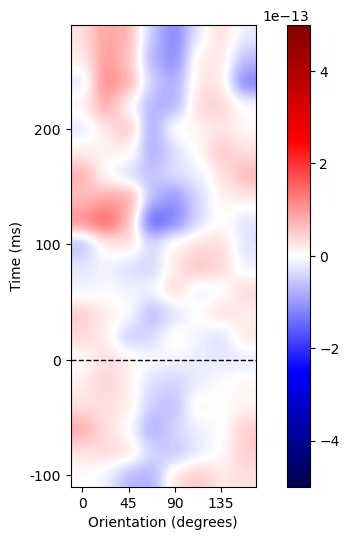

In [33]:
max_abs = 5e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow(Xhat_centeredmean_deci0.T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
# add a y = 0 dashed line 
# add a y = 0 dashed line 
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=5.5, color='purple', linewidth=1)
# ax.axhline(y=11.5, color='magenta', linewidth=1)
# ax.axhline(y=17.5, color='orange', linewidth=1)


cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()


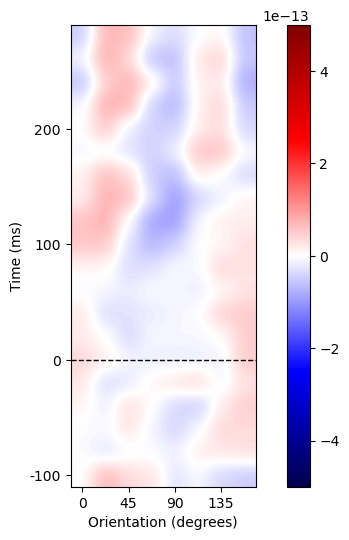

In [34]:
max_abs = 5e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow(Xhat_centeredmean_deci1.T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
# add a y = 0 dashed line 
# add a y = 0 dashed line 
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=5.5, color='purple', linewidth=1)
# ax.axhline(y=11.5, color='magenta', linewidth=1)
# ax.axhline(y=17.5, color='orange', linewidth=1)


cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()

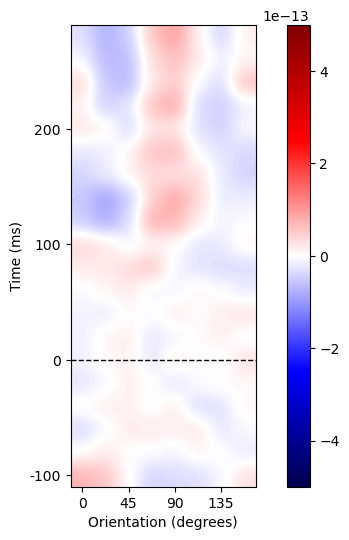

In [31]:
max_abs = 5e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow(Xhat_centeredmean_deci0_ort.T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
# add a y = 0 dashed line 
# add a y = 0 dashed line 
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=5.5, color='purple', linewidth=1)
# ax.axhline(y=11.5, color='magenta', linewidth=1)
# ax.axhline(y=17.5, color='orange', linewidth=1)


cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()

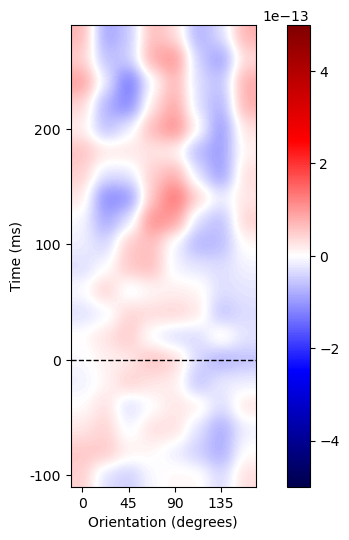

In [32]:
max_abs = 5e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow(Xhat_centeredmean_deci1_ort.T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
# add a y = 0 dashed line 
# add a y = 0 dashed line 
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=5.5, color='purple', linewidth=1)
# ax.axhline(y=11.5, color='magenta', linewidth=1)
# ax.axhline(y=17.5, color='orange', linewidth=1)


cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()

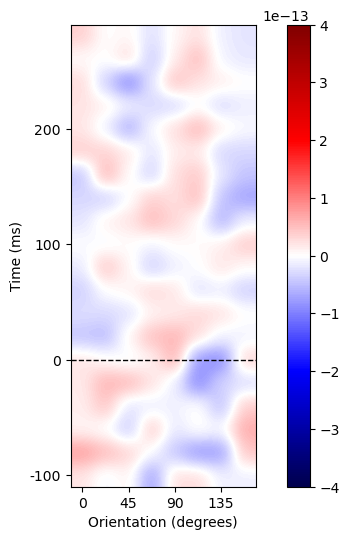

In [ ]:
max_abs = 4e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow((Xhat_centeredmean_rep_2-Xhat_centeredmean_rep_0).T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
# add a y = 0 dashed line 
# add a y = 0 dashed line 
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)



cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

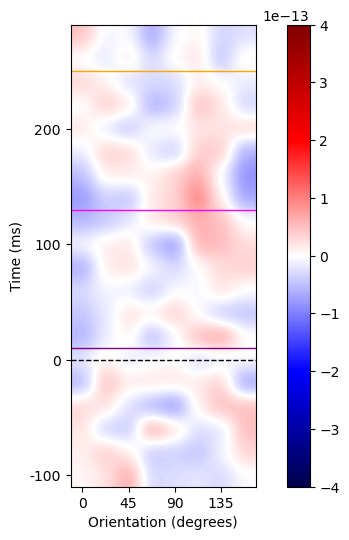

In [ ]:

max_abs = 4e-13
fig, ax = plt.subplots(figsize=(8, 6)) 
im = ax.imshow((Xhat_centeredmean_rep_1-Xhat_centeredmean_rep_0).T, vmin=-max_abs, vmax=max_abs, origin='lower', cmap='seismic', interpolation='gaussian')
ax.set_yticks(range(len(time_labels)), time_labels)
ax.set_yticks(ax.get_yticks()[::5])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Orientation (degrees)')  
x_labels = x_labels.astype(int)
ax.set_xticks(range(len(x_labels)), x_labels)
ax.set_xticks(ax.get_xticks()[::2])
ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
# add horitzontal lines with sns.lineplot with colors

# sns.lineplot()
ax.axhline(y=5.5, color='purple', linewidth=1)
ax.axhline(y=11.5, color='magenta', linewidth=1)
ax.axhline(y=17.5, color='orange', linewidth=1)

cbar = fig.colorbar(im, ax=ax)
# plt.tight_layout()
plt.show()

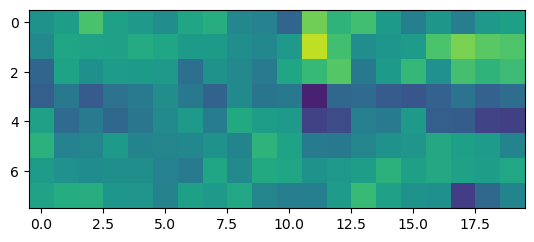

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci0, vmin=-max_abs, vmax=max_abs)

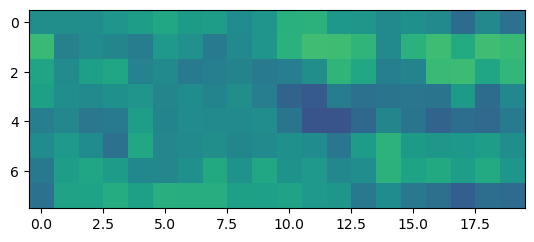

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci1, vmin=-max_abs, vmax=max_abs)

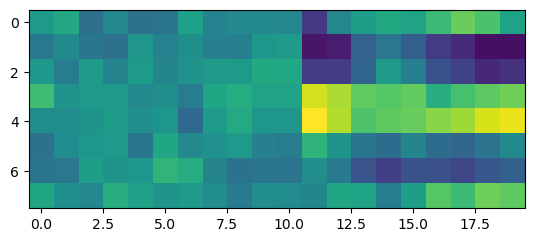

In [ ]:
im = plt.imshow(Xhat_centeredmean_ort, vmin=-max_abs, vmax=max_abs)

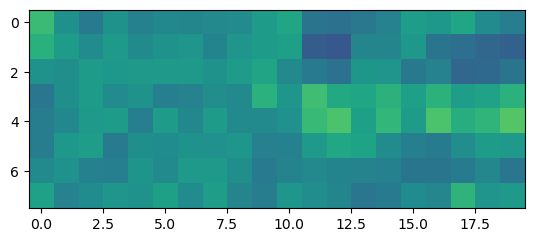

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci0_ort, vmin=-max_abs, vmax=max_abs)

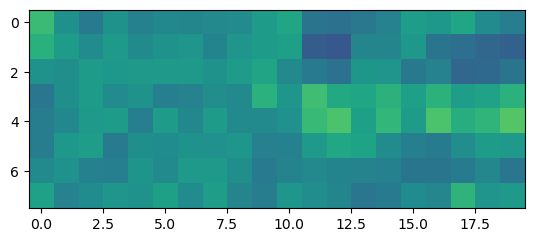

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci0_ort, vmin=-max_abs, vmax=max_abs)

substractions

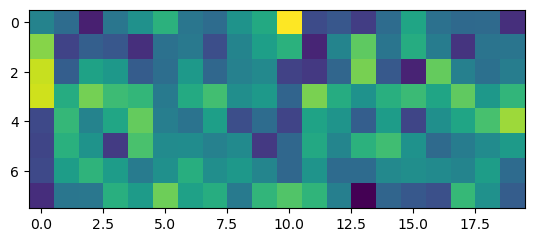

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci1 - Xhat_centeredmean_deci0)# , vmin=-max_abs, vmax=max_abs)

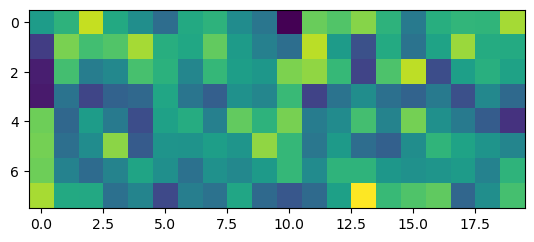

In [ ]:
im = plt.imshow(Xhat_centeredmean_deci0 - Xhat_centeredmean_deci1)#, vmin=-max_abs, vmax=max_abs)

In [ ]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
'''5 min 20hz'''

all_st_rawdata_rep = [None]*3
Xhat_centeredmean_rep = [None]*3

for i in range(1):
    print(i)
    all_st_rawdata_rep[i] = read_data(number_of_repetition=i, resample=False, resample_frequency=20)
    Xhat_centeredmean_rep[i] = train(all_st_rawdata_rep[i])

0
(32, 201, 518)
preds (8, 518, 201)
(32, 201, 450)
preds (8, 518, 201)
(32, 201, 503)
preds (8, 518, 201)
(32, 201, 438)
preds (8, 518, 201)
(32, 201, 495)
preds (8, 518, 201)
(32, 201, 440)
preds (8, 518, 201)
(32, 201, 514)


KeyboardInterrupt: 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

max_abs = np.max(np.abs(Xhat_centeredmean_rep))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[2], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 2')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()



/var/folders/x2/l6kq7w2s48bbjcgczm1ll_fm0000gn/T/ipykernel_96566/651682221.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max_abs = np.max(np.abs(Xhat_centeredmean_rep))


TypeError: bad operand type for abs(): 'NoneType'

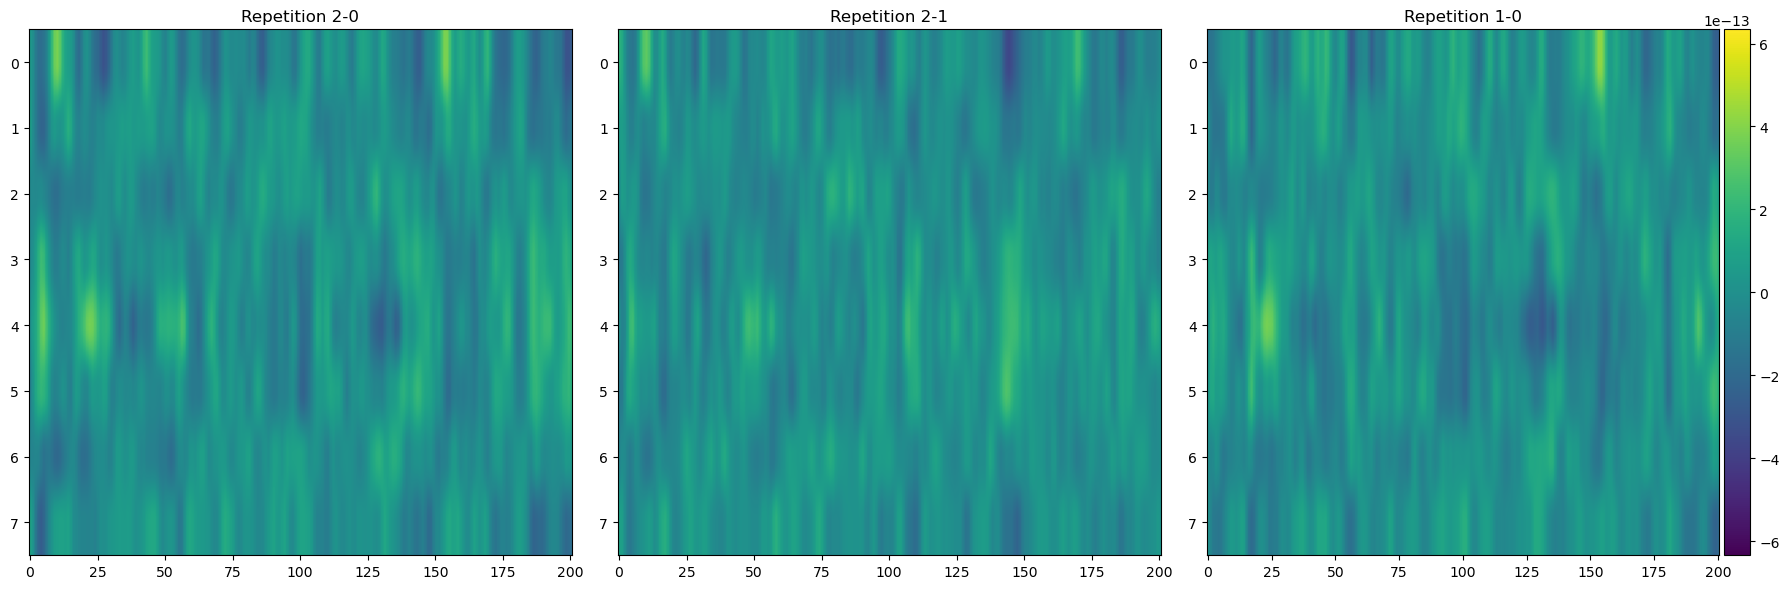

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 2-0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 2-1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[1] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 1-0')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()


In [ ]:
stophere

NameError: name 'stophere' is not defined



'''

Cluster based simulation, buscarlo en mne

'''


https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
